<a href="https://colab.research.google.com/github/andcov/CanSatML/blob/main/CanSatML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CanSat 2022

## Introduction
A CNN trained to classify satelite images in three categories:
* buildings
* forest
* field

It will be potentially used for targeted landings.

## Global Settings

## Setup

In [122]:
import tensorflow as tf

from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

from PIL import Image
from itertools import product
import glob
import os
import random

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
class_names = ['buildings', 'forest', 'field'] # order matters

# Load model

You can either load a model, or train a new one

In [141]:
model_path = '/content/gdrive/MyDrive/Programming/CanSatML/tf_checkpoint_2022_05_03_14:58/model/'
model = tf.keras.models.load_model(model_path)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 64)       

# Create model

## Get data

The data set consists of about 4000 images saved in three different folders based on their label. The labels are:
* buildings = 0
* forest = 1
* field = 2

### Helpers

In [6]:
def get_data(path):
  data = []

  for filename in glob.glob(os.path.normpath(path) + '/*.jpg'):
    if os.path.getsize(filename) == 0:
      continue
    img = Image.open(filename)
    img_data = np.asarray(img)
    data.append(img_data)

  return data

In [7]:
def label_data(data, label):
  labeled_data = []
  for d in data:
    labeled_data.append((d, label))
  return labeled_data

In [8]:
def split_dataset(data, testing_percentage):
  testing_len = int(len(data) * testing_percentage)
  return (data[testing_len:], data[:testing_len])

### Read data from Google Drive

In [9]:
# Read data as Python lists containing images as ndarrays
buildings_data = get_data("/content/gdrive/My Drive/Programming/CanSatML/ML/buildings")
forest_data = get_data("/content/gdrive/My Drive/Programming/CanSatML/ML/forest")
field_data = get_data("/content/gdrive/My Drive/Programming/CanSatML/ML/field")


In [10]:
new_buildings_data = get_data("/content/gdrive/MyDrive/Programming/CanSatML/new_building_data/results")
buildings_data = buildings_data + new_buildings_data

new_forest_data = get_data("/content/gdrive/MyDrive/Programming/CanSatML/new_forest_data/results")
forest_data = forest_data + new_forest_data

new_field_data = get_data("/content/gdrive/MyDrive/Programming/CanSatML/new_field_data/results")
field_data = field_data + new_field_data

In [11]:
print("# of buildings images: ", len(buildings_data))
print("# of forest images: ", len(forest_data))
print("# of field images: ", len(field_data))

# of buildings images:  2270
# of forest images:  2307
# of field images:  2410


### Proccess data

Add labels to images.

In [12]:
labeled_buildings_data = label_data(buildings_data, 0)
labeled_forest_data = label_data(forest_data, 1)
labeled_field_data = label_data(field_data, 2)

Split data in training and testing samples.

In [13]:
testing_percentage = 0.15

(buildings_training, buildings_testing) = split_dataset(labeled_buildings_data, testing_percentage)
(forest_training, forest_testing) = split_dataset(labeled_forest_data, testing_percentage)
(field_training, field_testing) = split_dataset(labeled_field_data, testing_percentage)

# Form final datasets
training_data = buildings_training + forest_training + field_training
testing_data = buildings_testing + forest_testing + field_testing
# Shuffle data points
random.shuffle(training_data)
random.shuffle(testing_data)

Convert datasets from Python lists to ndarrays.

In [14]:
nd_training_data = []
nd_training_labels = []
nd_testing_data = []
nd_testing_labels = []

for d in training_data:
  nd_training_data.append(d[0])
  nd_training_labels.append(np.array([d[1]]))

for d in testing_data:
  nd_testing_data.append(d[0])
  nd_testing_labels.append(np.array([d[1]]))

(train_images, train_labels) = (np.asarray(nd_training_data), np.asarray(nd_training_labels))
(test_images, test_labels) = (np.asarray(nd_testing_data), np.asarray(nd_testing_labels))

### Verify images

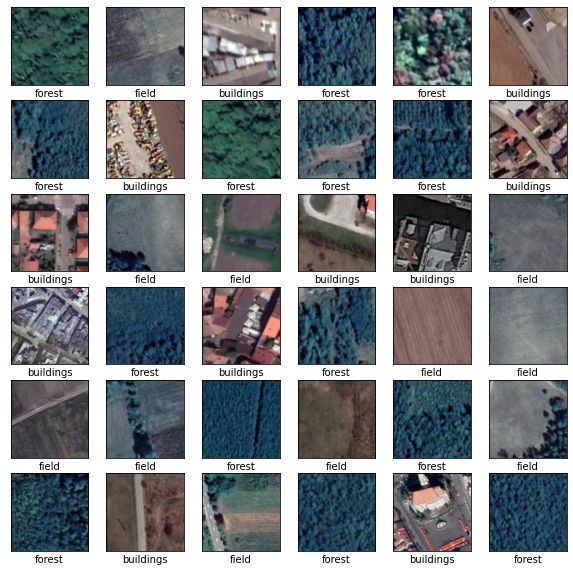

In [15]:
plt.figure(figsize = (10, 10))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if i % 2 == 0:
      plt.imshow(train_images[i])
      plt.xlabel(class_names[train_labels[i][0]])
    else:
      plt.imshow(test_images[i])
      plt.xlabel(class_names[test_labels[i][0]])
plt.show()

## Build model

In [135]:
model = []

model = models.Sequential()
model.add(layers.Input(shape=(120, 120, 3)))
model.add(layers.Rescaling(scale=1 / 255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 57, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 64)       

## Train model

In [ ]:
epochs = 1

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

### Save model

In [139]:
save_path = '/content/gdrive/MyDrive/Programming/CanSatML/tf_checkpoint_2022_05_03_14:58/model/'
model.save(save_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Programming/CanSatML/tf_checkpoint_2022_05_03_14:58/model/assets


# Test model

33/33 - 5s - loss: 0.4611 - accuracy: 0.8672 - 5s/epoch - 139ms/step


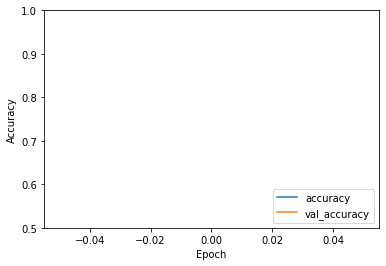

In [143]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

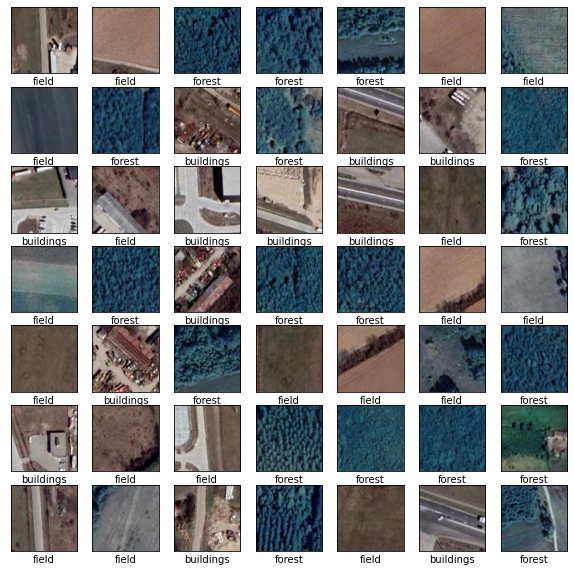

In [145]:
plt.figure(figsize = (10, 10))
predictions = model.predict(test_images[50:99])

for i in range(49):
    plt.subplot(7, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[50+i])

    max_pos = 0
    for pred in range(3):
      if predictions[i][pred] > predictions[i][max_pos]:
        max_pos = pred
    plt.xlabel(class_names[max_pos])
plt.show()

# Heatmap

## Helpers

In [149]:
def crop_image(img_path, size = 120):
  img = Image.open(img_path)
  w, h = img.size
  
  # get coords for images `size` sized apart
  grid = product(range(0, h - h % size, size), range(0, w - w % size, size))
  imgs = []
  for y, x in grid:
    imgc = img.crop((x, y, x + size, y + size))
    imgs.append(np.asarray(imgc))
  return imgs

In [156]:
ncolors = 256
old_colors = ['Blues', 'Greens', 'Oranges']
new_colors = ['Blues_alpha', 'Greens_alpha', 'Oranges_alpha']
for i in range(3):
  color_array = plt.get_cmap(old_colors[i])(range(ncolors))
  color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
  map_object = LinearSegmentedColormap.from_list(name=new_colors[i],colors=color_array)
  plt.register_cmap(cmap=map_object)

## Code

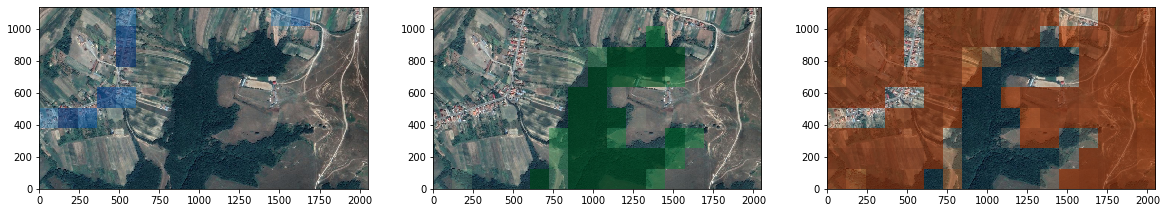

In [158]:
image_path = '/content/big_img3.jpeg'

big_image = Image.open(image_path)
w, h = big_image.size
big_image = np.asarray(big_image)

images = crop_image(image_path)
images = np.asarray(images)

predictions = model.predict(images)

extent = 0, w, 0, h
plt.figure(figsize = (20, 20))

cmaps = ['Blues_alpha', 'Greens_alpha', 'Oranges_alpha']

for i in range(3):
  plt.subplot(1, 3, i + 1)
  im = plt.imshow(big_image, interpolation='nearest', extent=extent)

  build = predictions[:,i].reshape((int(h / 120), int(w/120)))
  plt.imshow(build, cmap=cmaps[i], alpha=.7, interpolation='nearest', extent=extent)

plt.show()